In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import copy
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import json
import os

In [8]:
!pip install  scikit-allel

In [9]:
!pip install pyBigWig

     |████████████████████████████████| 64 kB 3.3 MB/s 
  Created wheel for pyBigWig: filename=pyBigWig-0.3.18-cp37-cp37m-linux_x86_64.whl size=194129 sha256=ba933b93952cf94fe95f3687de979385b781ea1a52e882b28b75b2516eeab0b5
  Stored in directory: /root/.cache/pip/wheels/28/eb/46/c761563ba38bd516bcc6accde3d4188cd84eec067f9201cbec
Successfully built pyBigWig


In [10]:

import allel
import pyBigWig
from google.colab import drive
drive.mount('/content/drive/')

parent_dir_name = 'CS194-172 Final Project'

for dirpath, subdirs, files in os.walk('/content/'):
  if parent_dir_name in subdirs:
    parent_path = dirpath + "/" + parent_dir_name

parent_path

Mounted at /content/drive/


'/content/drive/.shortcut-targets-by-id/1bNsJ-cxXG0DtLjAAE_uUPJ7L_GkhuM_i/CS194-172 Final Project'

In [ ]:
missense = allel.vcf_to_dataframe(parent_path + '/clinvar_missense.vcf', fields='*', alt_number=1)

/usr/local/lib/python3.7/dist-packages/allel/io/vcf_read.py:1736: UserWarning: multiple INFO headers for 'GENEINFO'
  warnings.warn('multiple INFO headers for %r' % k)


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp
0,1,925952,1019397,G,A,NaN,NaN,NaN,NaN,1003021,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.925952G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
1,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
2,1,930188,846933,G,A,NaN,NaN,NaN,NaN,824438,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930188G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
3,1,930200,1043045,G,A,NaN,NaN,NaN,NaN,1023510,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930200G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
4,1,930203,972363,C,T,NaN,NaN,NaN,NaN,959431,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930203C>T,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26091,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY:6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,0,True
26092,Y,2787551,9754,C,T,NaN,NaN,0.00009,NaN,24793,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787551C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0021|UniProtKB_(pr...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894971,-1,False,1,0,True
26093,Y,7063898,625467,A,T,NaN,0.00123,0.00048,NaN,613772,Deafness,NaN,MONDO:MONDO:0027048,NaN,NC_000024.10:g.7063898A>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:400033.0001,NaN,TBL1Y:90665,SO:0001583|missense_variant,1,199659121,-1,False,1,0,True
26094,Y,14622379,559565,G,A,NaN,NaN,NaN,NaN,550288,not_provided,NaN,MedGen:CN517202,NaN,NC_000024.10:g.14622379G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,NLGN4Y:22829,SO:0001583|missense_variant,32,1556057385,-1,False,1,0,True


In [ ]:
#Keep pathogenic and benign variants only, assign class label of 1 to pathogenic and 0 to benign
missense = missense[(missense['CLNSIG'] == 'Pathogenic') | (missense['CLNSIG'] == 'Benign')]
missense['Class label']= np.where(missense['CLNSIG']=='Pathogenic', 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label
1,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
5,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
10,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
11,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
20,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26089,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1
26090,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1
26091,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY:6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,0,True,1
26092,Y,2787551,9754,C,T,NaN,NaN,0.00009,NaN,24793,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787551C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0021|UniProtKB_(pr...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894971,-1,False,1,0,True,1


**Part 1: Features Selection** 
- RVIS Score
-PhastCons Value 
-O/E Value 
-Exac_pLI Value 
-Xpresso
-GDI Index
-CAAD: [CADD_score, Grantham, PolyPhenVal ,SIFTval]

**RVIS Score**



In [ ]:
#Read data set and drop unnecessary columns 
rvis_data = pd.read_csv(parent_path + '/RVIS_Unpublished_ExACv2_March2017.txt', delimiter="\t")
rvis_data = rvis_data.drop(columns=['%geneCov', 'RVIS[pop_maf_0.05%(any)]', 'Edge_case_RVIS[pop_maf_0.05%(any)]', 'OE-ratio_[ExAC v2]', 'alternative-RVIS[maf_0.0025%]', 'alternative-%RVIS[maf_0.0025%]', '%OE-ratio_[ExAC v2]'])
rvis_data = rvis_data.set_index("CCDSr20")

#Clean up GENEINFO column to merge rviz values 
missense['GENEINFO'] = missense['GENEINFO'].str.replace(':', ' ')
missense['GENEINFO'] = missense['GENEINFO'].str.replace('|', ' ')
missense[['GENE1', 'NUM1', 'GENE2', 'NUM2']] =  missense['GENEINFO'].str.split(' ', 3, expand=True)

missense = pd.merge(missense, rvis_data, left_on="GENE1", right_on="CCDSr20", how="left")
missense['%RVIS[pop_maf_0.05%(any)]'] = missense['%RVIS[pop_maf_0.05%(any)]'].replace(np.nan, 50)
missense= missense.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "first rvis"})
missense = pd.merge(missense, rvis_data, left_on="GENE2", right_on="CCDSr20", how="left")
missense= missense.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "second rvis"})
missense["second rvis"] = missense[missense['GENE2'].values != None]["second rvis"].replace(np.nan, 50)

#Take average of gene1 and gene2 rvis values 
missense["mean RVIS score"] =  missense[["first rvis", "second rvis"]].mean(axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'RVIS')

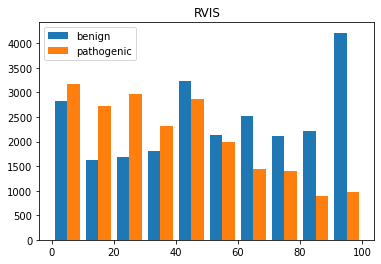

In [ ]:
#plot histogram 
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['mean RVIS score'], pathogenic['mean RVIS score']], label=names)
plt.legend()
plt.title("RVIS")

**PhastCons Value**

In [ ]:
#Extract phastCons data and append it to variants
phastcons_data = pyBigWig.open(parent_path + "/hg38.phastCons100way.bw")
missense["phastCons"] = [phastcons_data.stats("chr" + x, y, y+1) for x, y in zip(missense["CHROM"],missense["POS"])]
missense["phastCons"] = missense["phastCons"].str[0]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'PhastCons')

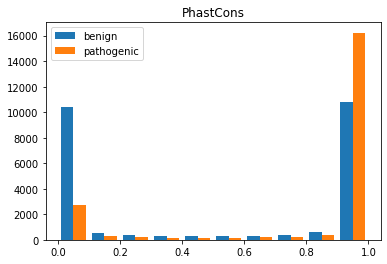

In [ ]:
#Plot a histogram
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['phastCons'], pathogenic['phastCons']], label=names)
plt.legend()
plt.title("PhastCons")

**O/E Value and 
Exac_pLI Value**

In [ ]:
#Extract gnomad data and append values to variants
gnomad_data = pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
missense = pd.merge(missense, gnomad_data, left_on="GENE1", right_on="gene", how="left")
missense["oe_lof_upper_rank"] = missense["oe_lof_upper_rank"].replace(np.nan, missense["oe_lof_upper_rank"].max()/2)
missense["exac_pLI"] = missense["exac_pLI"].replace(np.nan, missense["exac_pLI"].max()/2)


In [ ]:
pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')


,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,possible_mis_pphen,obs_syn,exp_syn,oe_syn,mu_syn,possible_syn,obs_lof,mu_lof,possible_lof,exp_lof,pLI,pNull,pRec,oe_lof,oe_syn_lower,oe_syn_upper,oe_mis_lower,oe_mis_upper,oe_lof_lower,oe_lof_upper,constraint_flag,syn_z,mis_z,lof_z,oe_lof_upper_rank,oe_lof_upper_bin,oe_lof_upper_bin_6,n_sites,classic_caf,max_af,no_lofs,obs_het_lof,obs_hom_lof,defined,p,exp_hom_lof,classic_caf_afr,classic_caf_amr,classic_caf_asj,classic_caf_eas,classic_caf_fin,classic_caf_nfe,classic_caf_oth,classic_caf_sas,p_afr,p_amr,p_asj,p_eas,p_fin,p_nfe,p_oth,p_sas,transcript_type,gene_id,transcript_level,cds_length,num_coding_exons,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,6708.0,422,387.530,1.08900,0.000019,4248,0.0,0.000005,1257.0,98.429,1.0,8.943600e-40,1.838300e-16,0.000000,1.005,1.180,0.736,0.824,0.000,0.030,NaN,-1.376500,2.623200,9.1935,0.0,0.0,0.0,2.0,0.000012,0.000008,124782.0,3.0,0.0,124785.0,0.000012,0.000018,0.000000,0.000000,0.000000,0.000000,0.000093,0.000009,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000009,0.0,0.000000,protein_coding,ENSG00000108510,2,6522,30,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,7135.0,496,495.010,1.00200,0.000025,5211,1.0,0.000009,1781.0,150.320,1.0,2.977300e-59,3.572400e-24,0.006653,0.930,1.079,0.554,0.621,0.001,0.032,NaN,-0.035119,5.573700,11.2860,1.0,0.0,0.0,2.0,0.000012,0.000008,125693.0,3.0,0.0,125696.0,0.000012,0.000018,0.000000,0.000000,0.000099,0.000000,0.000000,0.000000,0.0,0.000065,0.000000,0.000000,0.000099,0.000000,0.000000,0.000000,0.0,0.000065,protein_coding,ENSG00000164190,2,8412,46,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,2197.0,215,203.250,1.05780,0.000010,2091,0.0,0.000005,937.0,79.490,1.0,2.785300e-32,2.191400e-13,0.000000,0.946,1.184,0.249,0.320,0.000,0.037,NaN,-0.647760,6.399900,8.2618,2.0,0.0,0.0,8.0,0.000032,0.000004,125731.0,8.0,0.0,125739.0,0.000032,0.000127,0.000000,0.000000,0.000099,0.000054,0.000000,0.000044,0.0,0.000033,0.000000,0.000000,0.000099,0.000054,0.000000,0.000044,0.0,0.000033,protein_coding,ENSG00000108055,2,3651,29,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,3560.0,470,456.030,1.03060,0.000024,4564,1.0,0.000007,1440.0,125.030,1.0,2.992400e-49,4.562900e-20,0.007998,0.955,1.112,0.403,0.464,0.002,0.038,NaN,-0.514100,7.254600,10.2790,3.0,0.0,0.0,5.0,0.000020,0.000004,125740.0,4.0,0.0,125744.0,0.000016,0.000032,0.000000,0.000029,0.000000,0.000055,0.000000,0.000026,0.0,0.000000,0.000000,0.000029,0.000000,0.000054,0.000000,0.000018,0.0,0.000000,protein_coding,ENSG00000125107,2,7128,48,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,4151.0,358,352.620,1.01530,0.000017,3482,0.0,0.000004,1024.0,73.222,1.0,8.405500e-30,2.284200e-12,0.000000,0.930,1.108,0.645,0.733,0.000,0.040,NaN,-0.225180,3.462000,7.9294,4.0,0.0,0.0,1.0,0.000004,0.000004,125122.0,1.0,0.0,125123.0,0.000004,0.000002,0.000062,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000062,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,protein_coding,ENSG00000117000,2,5742,8,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
missense = pd.merge(missense, gnomad_data, left_on="GENE1", right_on="gene", how="left")
missense["oe_lof_upper_rank"] = missense["oe_lof_upper_rank"].replace(np.nan, missense["oe_lof_upper_rank"].max()/2)
missense["exac_pLI"] = missense["exac_pLI"].replace(np.nan, missense["exac_pLI"].max()/2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'O/E')

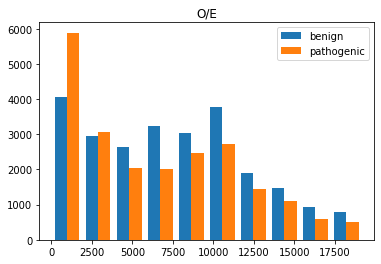

In [ ]:
#Plot histograms
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['oe_lof_upper_rank'], pathogenic['oe_lof_upper_rank']], label=names)
plt.legend()
plt.title("O/E")


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'exac_pLI')

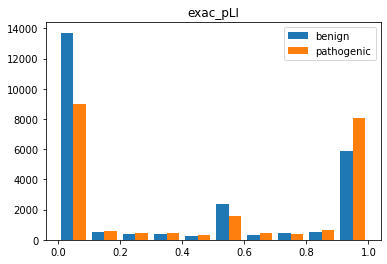

In [ ]:
#Plot histograms
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign["exac_pLI"], pathogenic["exac_pLI"]], label=names)
plt.legend()
plt.title("exac_pLI")

**Gene Expression Level**

In [11]:
# from Xpresso dataset
# read by default 1st sheet of an excel file
dataframe1 = pd.read_excel(parent_path + "/xpresso.xlsx")
Xpresso = dataframe1[['Unnamed: 1', 'Unnamed: 63']][2:]
Xpresso = Xpresso.rename(columns={'Unnamed: 1':"Gene Name", 'Unnamed: 63':"Median expression" })[1:]
missense = pd.merge(missense, Xpresso, left_on="GENE1", right_on="Gene Name", how="left")
missense["Median expression"] = missense["Median expression"].replace(np.nan, 0)
missense = missense.rename(columns = {"Median expression": "median_expression_level_1"})

missense = pd.merge(missense, Xpresso, left_on="GENE2", right_on="Gene Name", how="left")
missense["Median expression"] = missense[missense['GENE2'].values != None]["Median expression"].replace(np.nan, 0)
missense = missense.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
missense["mean gene_expression_level"] =  missense[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
missense = missense.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,mean gene_expression_level
0,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.206
1,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.206
2,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.206
3,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.206
4,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45096,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.000
45097,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.000
45098,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY 6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.000
45099,Y,2787551,9754,C,T,NaN,NaN,0.00009,NaN,24793,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787551C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0021|UniProtKB_(pr...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894971,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.000


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


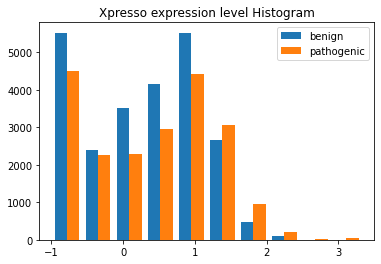

In [ ]:
plt.hist([missense[missense["Class label"] == 0 ]["mean gene_expression_level"],missense[missense["Class label"] == 1 ]["mean gene_expression_level"]], label = ["benign", "pathogenic"])  
plt.title('Xpresso expression level Histogram')


plt.legend(loc='upper right')

**GDI Index**

In [ ]:
import re
gdi_data = pd.read_csv(parent_path + "/GDI_full.txt",  delimiter="\t")
gdi_data = gdi_data[["Gene", "GDI-Phred"]]
gdi_data = gdi_data.rename(columns={"Gene": "Gene Name", "GDI-Phred":"Median expression"})


missense = pd.merge(missense, gdi_data, left_on="GENE1", right_on="Gene Name", how="left")
missense["Median expression"] = missense["Median expression"].replace(np.nan, missense["Median expression"].max()/2)
missense = missense.rename(columns = {"Median expression": "median_expression_level_1"})

missense = pd.merge(missense, gdi_data, left_on="GENE2", right_on="Gene Name", how="left")
missense["Median expression"] = missense[missense['GENE2'].values != None]["Median expression"].replace(np.nan, missense["Median expression"].max()/2)
missense = missense.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
missense["GDI"] =  missense[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
missense = missense.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


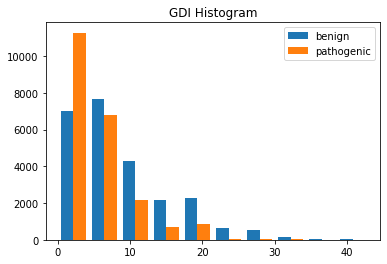

In [ ]:
plt.hist([missense[missense["Class label"] == 0 ]["GDI"],missense[missense["Class label"] == 1 ]["GDI"]], label = ["benign", "pathogenic"])  
plt.title('GDI Histogram')


plt.legend(loc='upper right')

**CADD**

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)

1. Create gzipped vcf file, with proper format and without extra data for speed

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)



new = missense[["CHROM", "POS", "ID", "REF", "ALT"]]
# new = new.iloc[0:20]
new["ALT"] = new["ALT"].apply(lambda row: row[0])
header = """##fileformat=VCFv4.1
#CHROM POS ID REF ALT
"""

output_VCF = "missense_data.vcf"
with open(output_VCF, 'w') as vcf:
    vcf.write(header)

new.to_csv(output_VCF, sep="\t", mode='a', index=False)

# import gzip
# import shutil
# with open('file.txt', 'rb') as f_in:
#     with gzip.open('file.txt.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)


# turn in to # https://cadd.gs.washington.edu/score with ANNOTATIONS selected

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2.Upload to https://cadd.gs.washington.edu/score **with ANNOTATIONS selected**
and cadd model GRCh38-v1.6

---



3. Upload resulting file to folder, below code reads as df

In [ ]:
import gzip
with gzip.open(parent_path +'/38-missense.tsv.gz', 'rt') as f:
  # with gzip.open('chr22_subsampled_snps.vcf.gz', 'rt') as f:
  lines = f.readlines()
  with open('caddunzipped.txt', 'w') as t:
    for line in lines[1:]:
        t.write(line)
        t.write('\n')
cadd_data = pd.read_csv('caddunzipped.txt', delimiter="\t")
cadd_data = cadd_data.rename(columns={"PHRED": "CADD_score"})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,129) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
cadd_data = cadd_data.drop_duplicates(
  subset = ['#Chrom', 'Pos'],
  keep = 'last').reset_index(drop = True)
cadd_data["#Chrom"] = cadd_data["#Chrom"].apply(lambda r:str(r))
  

In [ ]:
cadd_data

,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,ConsDetail,GC,CpG,motifECount,motifEName,motifEHIPos,motifEScoreChng,oAA,nAA,GeneID,FeatureID,GeneName,CCDS,Intron,Exon,cDNApos,relcDNApos,CDSpos,relCDSpos,protPos,relProtPos,Domain,Dst2Splice,Dst2SplType,minDistTSS,minDistTSE,SIFTcat,SIFTval,PolyPhenCat,PolyPhenVal,priPhCons,...,EncodeH3K27me3-max,EncodeH3K36me3-sum,EncodeH3K36me3-max,EncodeH3K79me2-sum,EncodeH3K79me2-max,EncodeH4K20me1-sum,EncodeH4K20me1-max,EncodeH2AFZ-sum,EncodeH2AFZ-max,EncodeDNase-sum,EncodeDNase-max,EncodetotalRNA-sum,EncodetotalRNA-max,Grantham,SpliceAI-acc-gain,SpliceAI-acc-loss,SpliceAI-don-gain,SpliceAI-don-loss,MMSp_acceptorIntron,MMSp_acceptor,MMSp_exon,MMSp_donor,MMSp_donorIntron,Dist2Mutation,Freq100bp,Rare100bp,Sngl100bp,Freq1000bp,Rare1000bp,Sngl1000bp,Freq10000bp,Rare10000bp,Sngl10000bp,EnsembleRegulatoryFeature,dbscSNV-ada_score,dbscSNV-rf_score,RemapOverlapTF,RemapOverlapCL,RawScore,CADD_score
0,1,930165,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.662,0.080,NaN,NaN,NaN,NaN,R,Q,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,166.0,0.065,83.0,0.041,28.0,0.041,hmmpanther,11.0,ACCEPTOR,148,5629,deleterious,0.00,possibly_damaging,0.778,0.939,...,4.68,6.49,1.87,4.46,1.26,10.54,2.04,4.80,1.20,0.62,0.17,0.67,0.30,43.0,0.00,0.0,0.00,0.0,0.0,0.000,0.023,0.0,0.0,6.0,0.0,1.0,19.0,1.0,17.0,196.0,40.0,115.0,1971.0,NaN,NaN,NaN,9.0,11.0,4.225333,28.900
1,1,930204,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.669,0.120,NaN,NaN,NaN,NaN,R,Q,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,205.0,0.080,122.0,0.060,41.0,0.060,hmmpanther,NaN,NaN,109,5590,deleterious,0.01,possibly_damaging,0.886,0.084,...,5.61,6.21,1.62,4.30,1.26,12.99,2.69,5.87,2.01,0.65,0.18,0.68,0.21,43.0,0.00,0.0,0.00,0.0,0.0,0.000,-0.090,0.0,0.0,9.0,0.0,3.0,23.0,1.0,17.0,196.0,40.0,114.0,1972.0,NaN,NaN,NaN,9.0,14.0,2.879554,23.200
2,1,930285,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.623,0.120,NaN,NaN,NaN,NaN,R,Q,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,286.0,0.112,203.0,0.099,68.0,0.100,hmmpanther,NaN,NaN,28,5509,tolerated,0.34,benign,0.001,0.005,...,4.63,9.82,4.72,7.44,2.00,17.17,3.29,10.70,4.03,0.60,0.14,0.49,0.24,43.0,0.00,0.0,0.00,0.0,0.0,0.000,-0.008,0.0,0.0,8.0,0.0,6.0,30.0,1.0,16.0,200.0,42.0,115.0,1982.0,NaN,NaN,NaN,13.0,18.0,0.091394,2.015
3,1,930314,C,T,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.649,0.120,NaN,NaN,NaN,NaN,H,Y,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,315.0,0.123,232.0,0.113,78.0,0.115,hmmpanther,NaN,NaN,2,5480,deleterious,0.04,possibly_damaging,0.637,0.042,...,6.22,8.49,3.96,8.31,3.60,17.78,3.80,11.69,4.03,0.59,0.22,0.75,0.46,83.0,0.00,0.0,0.07,0.0,0.0,-0.204,-0.252,0.0,0.0,2.0,0.0,5.0,30.0,1.0,16.0,206.0,41.0,114.0,1974.0,NaN,NaN,NaN,13.0,18.0,2.481464,22.400
4,1,935779,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.662,0.147,NaN,NaN,NaN,NaN,G,S,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,5/14,396.0,0.155,313.0,0.153,105.0,0.154,hmmpanther,8.0,ACCEPTOR,5467,15,tolerated,1.00,benign,0.000,0.425,...,23.92,7.08,2.14,10.06,5.40,17.69,5.28,15.21,3.26,1.32,0.64,0.91,0.73,56.0,0.13,0.0,0.00,0.0,0.0,0.000,-0.290,0.0,0.0,15.0,0.0,1.0,26.0,2.0,17.0,268.0,30.0,112.0,2032.0,NaN,NaN,NaN,25.0,40.0,1.831757,17.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43890,Y,2787412,C,T,SNV,0,Intergenic,UPSTREAM,1,upstream,0.490,0.120,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000237659,ENST00000454281,RNASEH2CP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288,557,NaN,NaN,NaN,NaN,0.293,...,5.12,5.55,2.97,1.54,0.64,1.81,0.98,10.06,3.99,0.43,0.31,0.22,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,23.0,2.3510

In [ ]:
cadd_columns = ["CADD_score", "Grantham", "PolyPhenVal" ,"SIFTval"]
cadd_data = cadd_data[["#Chrom", "Pos"]+cadd_columns]
cadd_missense_merged = pd.merge(left = missense, right = cadd_data, left_on = ["CHROM", "POS"], right_on=["#Chrom", "Pos"],how="left")
for col in cadd_columns:
  cadd_missense_merged[col] = cadd_missense_merged[col].replace(np.nan, cadd_missense_merged[col].max()/2) 

In [ ]:
cadd_missense_merged

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI,GDI,#Chrom,Pos,CADD_score,Grantham,PolyPhenVal,SIFTval
0,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.437,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,1,930165,28.900,43.0,0.778,0.00
1,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.978,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,1,930204,23.200,43.0,0.886,0.01
2,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.168,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,1,930285,2.015,43.0,0.001,0.34
3,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.006,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,1,930314,22.400,83.0,0.637,0.04
4,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,1.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,1,935779,17.970,56.0,0.000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46609,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,1.000,SRY,9597.5,4.160200e-01,SRY,NaN,4.160200e-01,SRY,9597.5,4.160200e-01,0.01646,Y,2787412,21.900,107.5,0.500,0.50
46610,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.997,SRY,9597.5,4.160200e-01,SRY,NaN,4.160200e-01,SRY,9597.5,4.160200e-01,0.01646,Y,2787426,21.000,107.5,0.500,0.50
46611,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_vari

In [ ]:
missense = cadd_missense_merged.drop(columns =["#Chrom", "Pos"])


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI,GDI,CADD_score,Grantham,PolyPhenVal,SIFTval
0,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.437,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,28.900,43.0,0.778,0.00
1,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.978,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,23.200,43.0,0.886,0.01
2,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.168,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,2.015,43.0,0.001,0.34
3,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.006,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,22.400,83.0,0.637,0.04
4,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,1.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,5.65821,17.970,56.0,0.000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46609,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,1.000,SRY,9597.5,4.160200e-01,SRY,NaN,4.160200e-01,SRY,9597.5,4.160200e-01,0.01646,21.900,107.5,0.500,0.50
46610,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.997,SRY,9597.5,4.160200e-01,SRY,NaN,4.160200e-01,SRY,9597.5,4.160200e-01,0.01646,21.000,107.5,0.500,0.50
46611,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY 6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

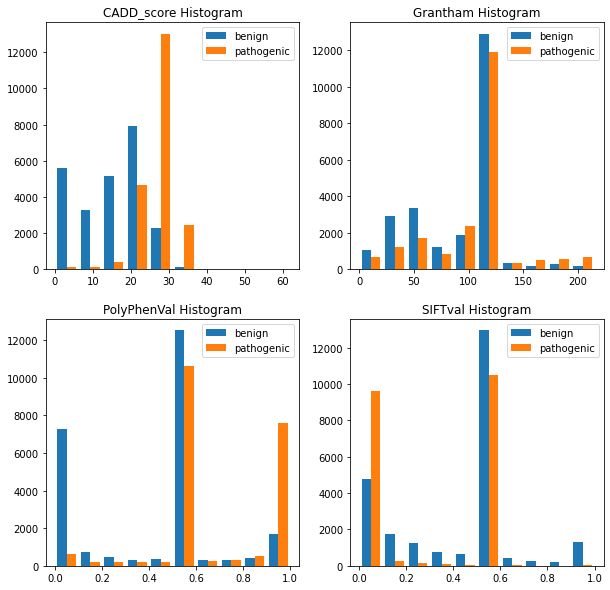

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(2):
    for j in range(2):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(cadd_columns):
            col = cadd_columns[counter]


            ax.hist([missense[missense["Class label"] == 0 ][col],missense[missense["Class label"] == 1 ][col]], label = ["benign", "pathogenic"])  
            ax.set_title(col + " Histogram")
            ax.legend(loc='upper right')

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()


**Model Training**

In [ ]:
missense.columns
c =["CHROM", "POS", "Class label", "mean RVIS score", "phastCons", "oe_lof_upper_rank", "exac_pLI", "GDI", "CADD_score", "Grantham", "PolyPhenVal", "SIFTval"]
for val in c:
  if val not in missense.columns:
    print(val)
missense_data = missense[c]

In [ ]:
training_set, validation_set= train_test_split(missense_data, test_size=0.2)

In [ ]:
training_set

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score,Grantham,PolyPhenVal,SIFTval
42322,X,2949691,0,50.000000,0.000,9597.5,5.000000e-01,21.45662,0.037,46.0,0.003,1.00
33445,16,89532481,1,16.412512,0.069,16493.0,1.384700e-18,8.54208,28.600,64.0,0.995,0.00
2151,1,153360788,0,49.951124,0.000,15184.0,6.674400e-01,0.39954,0.097,56.0,0.001,0.97
3438,1,219915901,1,47.018573,0.890,1697.0,9.218700e-01,1.12117,26.300,83.0,0.999,0.00
3120,1,202318836,0,53.059629,0.000,6389.0,4.088500e-05,5.76241,0.001,58.0,0.000,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...
17103,7,138771243,0,76.568915,1.000,10733.0,1.943400e-12,7.05075,17.430,64.0,0.000,0.19
3160,1,204424953,0,59.511241,0.957,2052.0,9.762400e-01,4.69353,10.130,107.5,0.500,0.50
41149,21,43418410,0,66.480938,0.988,2858.0,9.938300e-01,6.76849,0.354,99.0,0.003,0.47
1885,1,119755452,1,36.705767,0.005,12955.0,1.061200e-08,1.69109,28.800,125.0,1.000,0.00


In [ ]:
validation_set

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score,Grantham,PolyPhenVal,SIFTval
39504,19,49645079,0,50.772239,0.998,1735.0,9.987900e-01,5.028030,24.800,107.5,0.500,0.50
11284,4,128943120,0,58.533724,1.000,9337.0,5.173200e-12,3.774580,25.000,107.5,0.500,0.50
10935,4,87615540,0,50.000000,0.001,12670.0,6.180200e-04,25.509620,15.780,107.5,0.500,0.50
21855,10,62813496,1,28.005865,1.000,6033.0,6.195400e-01,1.080830,29.600,107.5,0.500,0.50
7996,3,33018482,1,43.294233,1.000,8994.0,4.864600e-08,8.222390,23.700,98.0,1.000,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
15839,7,31692470,0,71.256109,0.974,7113.0,2.707000e-04,5.631000,17.050,107.5,0.500,0.50
12930,5,149833239,0,76.451613,0.000,3210.0,9.340500e-01,8.793680,14.580,107.5,0.500,0.50
7687,3,10149815,1,45.009775,1.000,9800.0,3.373500e-02,7.316725,24.400,24.0,0.569,0.02
5047,2,98236669,0,86.432063,0.452,9960.0,3.265200e-18,7.720220,23.300,98.0,0.900,0.01


In [ ]:
X_train = training_set.drop(columns=["Class label", "CHROM", "POS"])
Y_train = training_set.loc[:, training_set.columns.intersection(['Class label'])]
X_test = validation_set.drop(columns=["Class label", "CHROM", "POS"])
Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]

In [ ]:
estimators = [50, 100, 150, 200, 250, 300, 350]
kf =KFold(n_splits=5, shuffle=True, random_state=42)
for count in estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= count, random_state= 42), X_train, Y_train, cv= kf, scoring= "accuracy")
    print(f'For estimators: {count}')
    print(score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 50
0.8865410485158322


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 100
0.8876137185596449


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 150
0.8875869125043669


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 200
0.8872919524202585


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 250
0.8877478207406891


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 300
0.8877478279311546


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 350
0.8881768758153763


In [ ]:
model = RandomForestClassifier(n_estimators= 350)

In [ ]:
model.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(n_estimators=350)

In [ ]:

Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]
accuracy_score(model.predict(X_test), Y_test)

0.8882334012656871

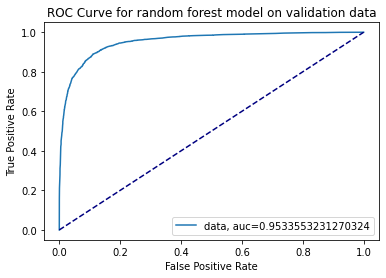

In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color="navy",linestyle="--")
plt.title("ROC Curve for random forest model on validation data")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()